# LVGP regresssion demonstration

In this example, we will demonstrate training and analyzing standard LVGP models on the borehole dataset. The metric used to assess the test performance is the relative root mean squared error (RRMSE), which is given by

$$
\mathrm{RRMSE} = \sqrt{
   \frac{\sum_{i=1}^{N}\left(y_i-\widehat{y}_i\right)^2}{\sum_{i=1}^{N} \left(y_i-\overline{y}\right)^2}
},   
$$

where $y_i$ and $\widehat{y}_i$ are respectively the true and predicted response for the $i^\mathrm{th}$ test sample, and $\overline{y}$ is the mean of the true test responses.

In [19]:
import torch
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from lvgp_pytorch.models import LVGPR
from lvgp_pytorch.optim import fit_model_scipy,noise_tune
from lvgp_pytorch.utils.variables import NumericalVariable,CategoricalVariable
from lvgp_pytorch.utils.input_space import InputSpace

from typing import Dict
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.dpi']=150
plt.rcParams['font.family']='serif'

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

## Generating the training and test sets

The borehole function is given by

$$
2\pi T_u\left(H_u-H_l\right)\left(
    \log\left(\frac{r}{r_w}\right)\left(
        1+ 2\frac{LT_u}{\log\left(r/r_w\right)r_w^2K_w} + \frac{T_u}{T_l}
    \right)
\right)^{-1}.
$$

In [2]:
def borehole(params:Dict)->float:
    numerator = 2*math.pi*params['T_u']*(params['H_u']-params['H_l'])
    den_term1 = math.log(params['r']/params['r_w'])
    den_term2 = 1+ 2*params['L']*params['T_u']/(den_term1*params['r_w']**2*params['K_w']) + \
        params['T_u']/params['T_l']
    
    return numerator/den_term1/den_term2

All 8 inputs are numerical. Similar to [Zhang et al. (2020)](https://doi.org/10.1080/00401706.2019.1638834), we discretize $r_w$ and $H_l$ over their domains to have 5 levels each.

We will be using the `lvgp_pytorch.utils.InputSpace` utility class to 

1. generating training and test data
2. transforming the inputs into the format required by `LVGPR`:
    - numerical/integer inputs are scaled to [0,1] (with/without log transform). 
    - categorical inputs are encoded as integers 0,...,L-1
3. transforming the array format back to the original scale for obtaining the response


We will now create the `InputSpace` object and add the associated variables.

In [3]:
# configuration space
config = InputSpace()
r = NumericalVariable(name='r',lower=100,upper=50000)
Tu = NumericalVariable(name='T_u',lower=63070,upper=115600)
Hu = NumericalVariable(name='H_u',lower=990,upper=1110)
Tl = NumericalVariable(name='T_l',lower=63.1,upper=116)
L = NumericalVariable(name='L',lower=1120,upper=1680)
K_w = NumericalVariable(name='K_w',lower=9855,upper=12045)

r_w = CategoricalVariable(name='r_w',levels=np.linspace(0.05,0.15,5))
H_l = CategoricalVariable(name='H_l',levels=np.linspace(700,820,5))
config.add_inputs([r,Tu,Hu,Tl,L,K_w,r_w,H_l])

config

Input space with variables:

r, Type: Numerical, Range: [100.0,50000.0]
T_u, Type: Numerical, Range: [63070.0,115600.0]
H_u, Type: Numerical, Range: [990.0,1110.0]
T_l, Type: Numerical, Range: [63.1,116.0]
L, Type: Numerical, Range: [1120.0,1680.0]
K_w, Type: Numerical, Range: [9855.0,12045.0]
r_w, Type: Categorical, Levels: {0.05, 0.075, 0.1, 0.125, 0.15}
H_l, Type: Categorical, Levels: {700.0, 730.0, 760.0, 790.0, 820.0}

We will generate 100 random samples to be used as training data and separately 1000 random samples to be used as test data.

In [4]:
np.random.choice([1,10,20,30,50, 1000],size = 2)

array([20,  1])

In [5]:
config.random_sample(np.random,10)

array([[0.51617817, 0.30769145, 0.51301462, 0.4482425 , 0.96282143,
        0.35291172, 4.        , 4.        ],
       [0.84252234, 0.048089  , 0.77736238, 0.12261439, 0.37907592,
        0.76049835, 2.        , 3.        ],
       [0.91400926, 0.61380308, 0.42908995, 0.21373228, 0.2956805 ,
        0.76514193, 1.        , 0.        ],
       [0.94303597, 0.00513854, 0.49367562, 0.56991468, 0.74194555,
        0.09208023, 4.        , 3.        ],
       [0.18817904, 0.18951567, 0.03324338, 0.81104125, 0.67011196,
        0.96365682, 2.        , 1.        ],
       [0.17468285, 0.8165095 , 0.7527159 , 0.00597671, 0.07251055,
        0.43808295, 3.        , 4.        ],
       [0.60594268, 0.9555987 , 0.41443501, 0.03883768, 0.4984342 ,
        0.23245424, 1.        , 4.        ],
       [0.04089737, 0.09471622, 0.80766998, 0.94589707, 0.41306956,
        0.26113839, 4.        , 1.        ],
       [0.27512066, 0.02244217, 0.1681722 , 0.89027892, 0.8631329 ,
        0.69514525, 3.      

In [6]:
config.get_dict_from_array(config.random_sample(np.random,10)[0])

{'r': 29601.842758536986,
 'T_u': 90564.00828441678,
 'H_u': 1018.5992501498854,
 'T_l': 74.01241864536948,
 'L': 1479.9756592601238,
 'K_w': 10487.115300154317,
 'r_w': 0.125,
 'H_l': 820.0}

In [18]:
# generate 100 samples
set_seed(1)
num_samples = 100
train_x = torch.from_numpy(
    config.random_sample(np.random,num_samples)
)
train_y = [None]*num_samples

for i,x in enumerate(train_x):
    train_y[i] = borehole(config.get_dict_from_array(x.numpy()))

train_y = torch.tensor(train_y).double()


# generate 1000 test samples
num_samples = 1000
test_x = torch.from_numpy(config.random_sample(np.random,num_samples))
test_y = [None]*num_samples

for i,x in enumerate(test_x):
    test_y[i] = borehole(config.get_dict_from_array(x.numpy()))
    
# create tensor objects
test_y = torch.tensor(test_y).to(train_y)

## Creating a LVGP instance

We begin by defining the `LVGPR` instance. The required input arguments are the training data (`train_x` and `train_y`), the indices for the qualitative (`qual_index`) and quantitative (`quant_index`) variables, and the number of levels for each qualitative variable (`num_levels_per_var`), whose entries are specified in the same as order as that in the index list. The `InputSpace` object automatically generates the latter three entries.

There are other arguments, which have default values. Among them, the important one is the type of the correlation kernel for the quantitative inputs (`quant_correlation_class`). Available options are `'RBFKernel'`(default), `Matern52Kernel` (twice-differentiable) and `Matern32Kernel`(once-differentiable). 

In [8]:
config.qual_index

[6, 7]

In [20]:
# create LVGP instance
set_seed(4)
model = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    quant_correlation_class="RBFKernel",
).double()

# print model structure
model


LVGPR(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-08)
    )
    (noise_prior): LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.99999993922529e-09)
  )
  (mean_module): ConstantMean(
    (mean_prior): NormalPrior()
  )
  (covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): RBFKernel(
          (raw_lengthscale_constraint): Positive()
          (lengthscale_prior): MollifiedUniformPrior(a: -2.3025851249694824, b: 2.3025851249694824, tail_sigma: 0.10000000149011612)
        )
      )
    )
    (raw_outputscale_constraint): Positive()
    (outputscale_prior): LogNormalPrior()
  )
  (lv_mapping_layers): ModuleList(
    (0): LVMapping(
      (first_latents_prior): NormalPrior()
      (rem_latents_prior): NormalPrior()
      (raw_precision_constraint): Positive()
      

Note that the hyperparameters of the model are not yet optimized!

## Optimization using multiple random starts

There are two optimization methods available in the package. In the first method, all hyperparameters are jointly optimized using multi-start numerical optimization with **L-BFGS** as the optimization algorithm.

In [17]:
# fit model with 10 different starts
reslist,nll_inc = fit_model_scipy(
    model,
    num_restarts=9, # number of starting points
)

# set model to eval model; default is in train model
_ = model.eval()

KeyboardInterrupt: 

In [11]:
# prediction on test set
with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_mean,test_std = model.predict(test_x,return_std=True)
    
# print RRMSE
rrmse = torch.sqrt(((test_y-test_mean)**2).mean()/((test_y-test_y.mean())**2).mean())
print('RRMSE : %5.3f'%rrmse.item())

RRMSE : 0.014


The test RRMSE seems to be pretty good. We now plot the estimated latent variables for the levels of $r_w$ and $H_l$. 

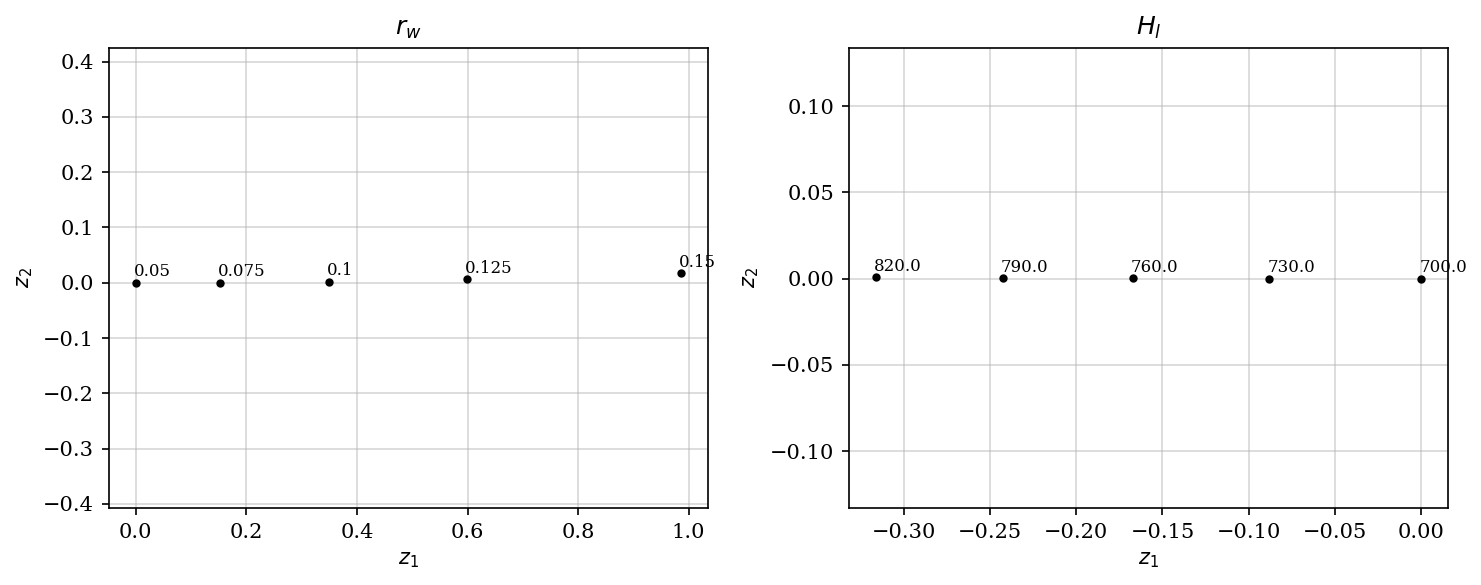

In [12]:
import matplotlib.pyplot as plt
# plot latent values
fig,axs = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    latents = model.lv_mapping_layers[i].latents.detach().numpy()
    _ = axs[i].plot(latents[:,0],latents[:,1],'k.')
    
    hyp = config.get_variable_by_idx(config.qual_index[i])
    # annotate the labels
    for j,level in enumerate(hyp.levels):
        _ = axs[i].annotate(
            str(level),latents[j,:],
            textcoords = 'offset points',
            xytext = (-1,3),
            size='8'
        )
        
    
    _ = axs[i].set_xlabel(r'$z_1$')
    _ = axs[i].set_ylabel(r'$z_2$')
    _ = axs[i].set_title(r'$%s$' %hyp.name)
    _ = axs[i].grid(alpha=0.5)
    _ = axs[i].set_aspect('equal', 'datalim')

fig.tight_layout()

The latent variables for both variable are effectively one-dimensional - the $z_2$ values do not change. This is expected as the qualitative variables are just discretized versions of the numerical variables.

## Alternate optimization strategy

In the second optimization method, the noise variance is varied along a decreasing sequence of values. At each iteration, the other hyperparameters are optimized using multi-start numerical optimization. The starting points at each iteration are the optimal solutions found in the previous iteration.

In [13]:
set_seed(4)
model2 = LVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    quant_correlation_class="RBFKernel",
).double()

# optimize noise successively
nll_inc_tuned,opt_history = noise_tune(
    model2, 
    num_restarts = 9 # number of restarts in the initial iteration
)

# 
print('NLL obtained from multi-start optimization....: %6.2f'%nll_inc)
print('NLL obtained from noise tuning strategy.......: %6.2f'%nll_inc_tuned)

# prediction on test set
with torch.no_grad():
    # set return_std = False if standard deviation is not needed
    test_mean2 = model2.predict(test_x,return_std=False)
    
print()
# print RRMSE
rrmse = torch.sqrt(((test_y-test_mean)**2).mean()/((test_y-test_y.mean())**2).mean())
print('Test RRMSE with noise-tuning strategy : %5.3f'%rrmse.item())

NLL obtained from multi-start optimization....: -148.13
NLL obtained from noise tuning strategy.......: -164.37

Test RRMSE with noise-tuning strategy : 0.014


In this case, the test RRMSEs with both methods are the same, even though the (negative) likelihoods are somewhat different. In problems with larger number of dimensions or larger number of levels, the `noise_tune` method will tend to perform better under the same computational budget.

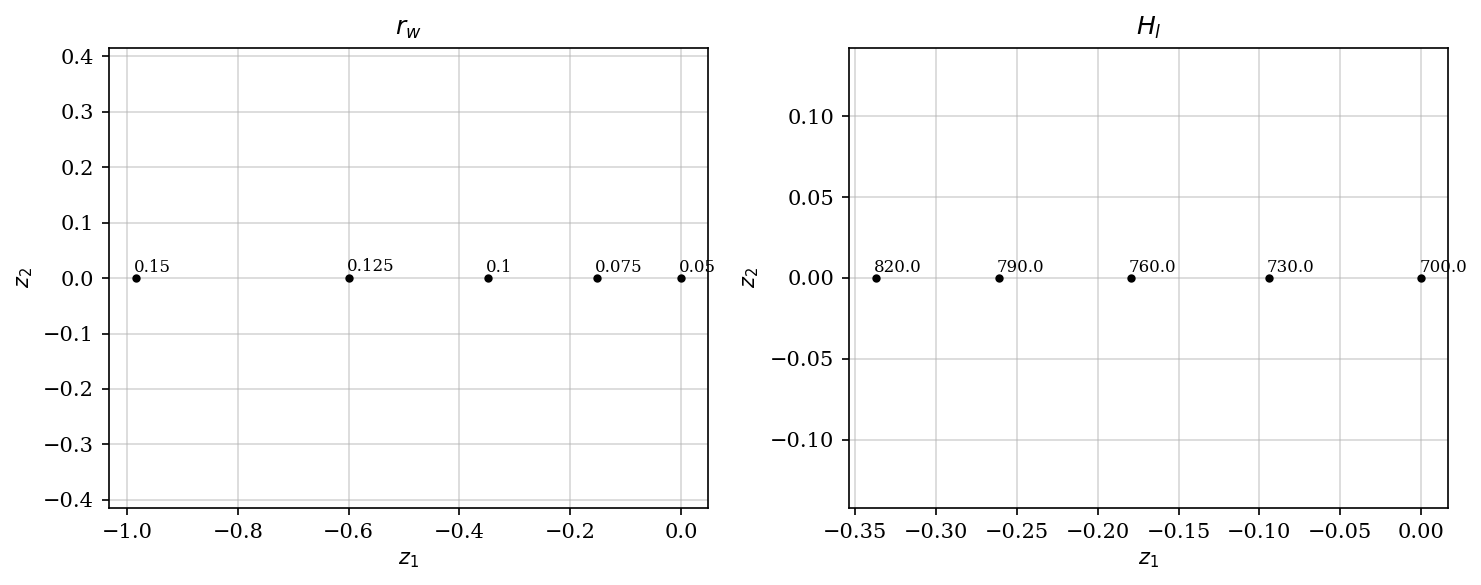

In [14]:
# plot latent values
fig,axs = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    latents = model2.lv_mapping_layers[i].latents.detach().numpy()
    _ = axs[i].plot(latents[:,0],latents[:,1],'k.')
    
    hyp = config.get_variable_by_idx(config.qual_index[i])
    # annotate the labels
    for j,level in enumerate(hyp.levels):
        _ = axs[i].annotate(
            str(level),latents[j,:],
            textcoords = 'offset points',
            xytext = (-1,3),
            size='8'
        )
        
    
    _ = axs[i].set_xlabel(r'$z_1$')
    _ = axs[i].set_ylabel(r'$z_2$')
    _ = axs[i].set_title(r'$%s$' %hyp.name)
    _ = axs[i].grid(alpha=0.5)
    _ = axs[i].set_aspect('equal', 'datalim')

fig.tight_layout()